In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
import itertools
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error
from typing import List, Union, Any, Tuple, Dict
import time
from permetrics.regression import RegressionMetric
import oapackage

import warnings
warnings.filterwarnings('ignore')

# Project path
ppath = sys.path[0] + '/../'
sys.path.append(os.path.join(ppath, 'code'))
from discretizers import *

This notebook explores the data imputation use case.

In [2]:
df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [21]:
# Randomly replace 20% of the Age column with NaN values
data = df.copy()
df_nan = df.sample(frac=0.3, random_state=42)
data.loc[df.index.isin(df_nan.index),'Age'] = np.nan

df_nan = df.sample(frac=0.3, random_state=1)
data.loc[df.index.isin(df_nan.index),'Glucose'] = np.nan

df_nan = df.sample(frac=0.3, random_state=2)
data.loc[df.index.isin(df_nan.index),'BMI'] = np.nan

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,NaN,72,35,0,33.6,0.627,50.0,1
1,1,85.0,66,29,0,NaN,0.351,31.0,0
2,8,183.0,64,0,0,23.3,0.672,NaN,1
3,1,NaN,66,23,94,NaN,0.167,21.0,0
4,0,137.0,40,35,168,43.1,2.288,33.0,1


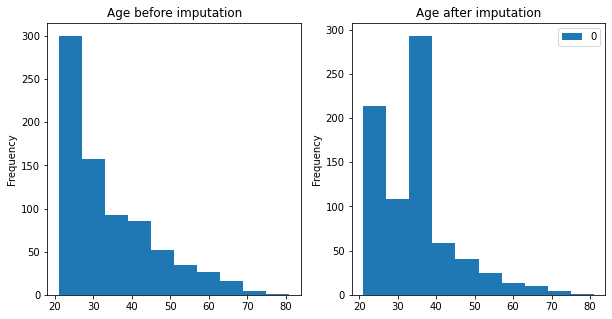

MAE imputation: 2.89453125
8.73668896216081


In [6]:
# Impute missing values using SimpleImputer in sklearn
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data_imputed = imp_mean.fit_transform(data['Age'].values.reshape(-1, 1))
data_imputed = np.round(data_imputed)

# Compare the distribution of Age before and after imputation
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
df['Age'].plot(kind='hist', ax=ax1, title='Age before imputation')
ax2 = fig.add_subplot(122)
pd.DataFrame(data_imputed).plot(kind='hist', ax=ax2, title='Age after imputation')
plt.show()

y_true = df['Age'].values
y_pred = data_imputed.flatten()
print('MAE imputation:', mean_absolute_error(y_true, y_pred))
evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.mean_relative_error()*100)

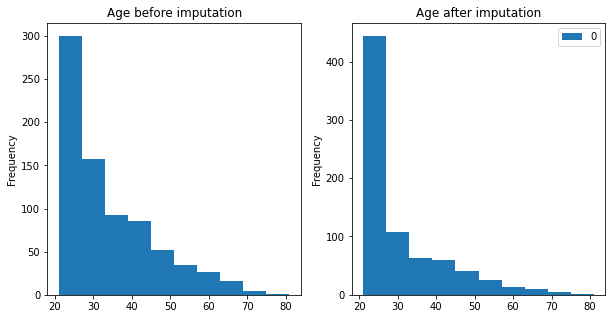

MAE imputation: 3.5247395833333335
8.381305780774468


In [23]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imputed = imp_mean.fit_transform(data['Age'].values.reshape(-1, 1))
data_imputed = np.round(data_imputed)

# Compare the distribution of Age before and after imputation
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
df['Age'].plot(kind='hist', ax=ax1, title='Age before imputation')
ax2 = fig.add_subplot(122)
pd.DataFrame(data_imputed).plot(kind='hist', ax=ax2, title='Age after imputation')
plt.show()

y_true = df['Age'].values
y_pred = data_imputed.flatten()
print('MAE imputation:', mean_absolute_error(y_true, y_pred))
evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.mean_relative_error()*100)

In [19]:
data1 = data.copy()
data1['Age'] = data_imputed
data1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50.0,1
1,1,85,66,29,0,26.6,0.351,31.0,0
2,8,183,64,0,0,23.3,0.672,33.0,1
3,1,89,66,23,94,28.1,0.167,21.0,0
4,0,137,40,35,168,43.1,2.288,33.0,1


### Test it out

In [3]:
# load json data from a file
import json
import ast
COLUMNS = ['Glucose', 'BMI', 'Age']
y_columns = [col+'.gt' for col in COLUMNS]
binnings = []
for s in COLUMNS:
    f = open(os.path.join(ppath, f'scratch/{s.lower()}_partitions.json'), "r")
    data = json.load(f)
    f.close()
    binnings.append(list(eval(data)))

In [22]:
strategy_combos = list(itertools.product(*binnings))
print("number of strategy combinations:", len(strategy_combos))

number of strategy combinations: 21952


In [6]:
strategy_combos[0]

({'bins': [0, 140, 200],
  'labels': ['0-140', '140-200'],
  'method': 'gold-standard',
  'gpt': 0.0},
 {'bins': [0, 18.5, 25, 30, 68],
  'labels': ['0-18.5', '18.5-25', '25-30', '30-68'],
  'method': 'gold-standard',
  'gpt': 0.0},
 {'bins': [0, 19, 45, 65, 85, 100],
  'labels': ['0-18', '19-44', '45-64', '65-84', '85-100'],
  'method': 'gold-standard',
  'gpt': 0.0,
  'l2_norm': 0.0,
  'spearman': 0.9999999999999999,
  'anova': 20.78361285152752})

In [23]:
# Randomly replace 20% of the Age column with NaN values
data = df.copy()
seeds = [1, 2, 42]
for i, col in enumerate(COLUMNS):
    data[f'{col}.gt'] = data[col]
    df_nan = df.sample(frac=0.3, random_state=seeds[i])
    data.loc[df.index.isin(df_nan.index),col] = np.nan

In [24]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose.gt,BMI.gt,Age.gt
0,6,NaN,72,35,0,33.6,0.627,50.0,1,148,33.6,50
1,1,85.0,66,29,0,NaN,0.351,31.0,0,85,26.6,31
2,8,183.0,64,0,0,23.3,0.672,NaN,1,183,23.3,32
3,1,NaN,66,23,94,NaN,0.167,21.0,0,89,28.1,21
4,0,137.0,40,35,168,43.1,2.288,33.0,1,137,43.1,33
...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76,48,180,32.9,0.171,NaN,0,101,32.9,63
764,2,122.0,70,27,0,NaN,0.340,NaN,0,122,36.8,27
765,5,NaN,72,23,112,26.2,0.245,30.0,0,121,26.2,30
766,1,126.0,60,0,0,NaN,0.349,47.0,1,126,30.1,47


In [25]:
#data = data.drop(columns=['Glucose', 'BMI'])
data['DiabetesPedigreeFunction.binned'] = pd.cut(data['DiabetesPedigreeFunction'], bins=[-1, 0.5, 1, 100], labels=[0.5, 1, 100])
data['DiabetesPedigreeFunction.binned'] = data['DiabetesPedigreeFunction.binned'].astype('float64')
data['Pregnancies.binned'] = pd.cut(data['Pregnancies'], bins=[-1, 2, 100], labels=[0, 1])
data['Pregnancies.binned'] = data['Pregnancies.binned'].astype('int64')
data['Insulin.binned'] = pd.cut(data['Insulin'], bins=[-1, 30, 120, 1000], labels=[30, 120, 1000])
data['Insulin.binned'] = data['Insulin.binned'].astype('int64')
data['BloodPressure.binned'] = pd.cut(data['BloodPressure'], bins=[-1, 60, 90, 100, 1000], labels=[60, 90, 100, 1000])
data['BloodPressure.binned'] = data['BloodPressure.binned'].astype('int64')
data['SkinThickness.binned'] = pd.cut(data['SkinThickness'], bins=[-1, 20, 40, 60, 80, 100], labels=[20, 40, 60, 80, 100])
data['SkinThickness.binned'] = data['SkinThickness.binned'].astype('int64')

data_X = data.drop(y_columns, axis=1)
data_y = data[y_columns]

In [26]:
imputer = KNNImputer(n_neighbors=5)
data_i = data_X.copy()
data_imputed = imputer.fit_transform(data_i)

In [27]:
data_imputed.shape

(768, 14)

### missing -> binning -> imputation

In [28]:
tree_depth = 5
col = 'Age'
outs = []
X_columns = ['Glucose.final', 'Pregnancies.binned', 'Insulin.binned', 'BMI.final', 'Age.final',
            'BloodPressure.binned', 'DiabetesPedigreeFunction.binned', 'SkinThickness.binned']

for strategy in strategy_combos:

    data_X = data.drop(y_columns, axis=1)
    data_y = data[y_columns]

    impute_accs = []
    semantics = []

    for i, col in enumerate(COLUMNS):
        data_i = data_X.copy()
        data_i_y = data_y.copy()
        bins = strategy[i]['bins']
        data_i[col + '.binned'] = pd.cut(data_i[col], bins=bins, labels=bins[1:])
        imputer = KNNImputer(n_neighbors=len(bins)-1)
        data_imputed = imputer.fit_transform(data_i)

        data_X[col+'.imputed'] = data_imputed[:, data_X.columns.get_loc(col)]
        data_X[col + '.final'] = pd.cut(data_X[col+'.imputed'], bins=bins, labels=bins[1:])
        data_X[col + '.final'] = data_X[col + '.final'].astype('float64')

        # Evaluate data imputation
        value_final = np.array(data_X[col+'.final'].values)
        value_final[np.isnan(value_final)] = -1
        value_final = np.round(value_final)
        data_i_y[col + '.gt'] = pd.cut(data_i_y[col + '.gt'], bins=bins, labels=bins[1:])
        data_i_y[col + '.gt'] = data_i_y[col + '.gt'].astype('float64')
        value_gt = np.array(data_i_y[col + '.gt'].values)
        value_gt[np.isnan(value_gt)] = -1
        value_gt = np.round(value_gt)
        #print(value_final)
        #print(value_gt)
        impute_accuracy = accuracy_score(value_gt, value_final)
        impute_accs.append(impute_accuracy)

        semantics.append(strategy[i]['gpt'])

    impute_accuracy = np.mean(impute_accs)
    semantic_score = np.mean(semantics)
    
    #data_X = data_X.dropna(subset=['Glucose.final','BMI.final','Age.final'])
    data_X = data_X.fillna(0)
    X = data_X[X_columns]
    y = data_X['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    #print(X_train[X_train.isna().any(axis=1)])
    #print(y_train[y_train.isna().any()])
    try: 
        clf = DecisionTreeClassifier(random_state=0,max_depth=tree_depth).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    except Exception as e: 
        print("Error:", e)
        #print(X_train[X_train.isna().any(axis=1)])
        print("Strategy:", i)
        #break
    
    binnings = [strategy[i]['bins'] for i in range(len(COLUMNS))]

    model_accuracy = accuracy_score(y_test, y_pred)
    #print(binnings, model_accuracy, 1-semantic_score, impute_accuracy)
    outs.append({'bins': binnings, 'model_accuracy': model_accuracy, 'Glucose.partitioned': np.array(data_X['Glucose.final']), 'BMI.partitioned': np.array(data_X['BMI.final']), 'Age.partitioned': np.array(data_X['Age.final']), 'gpt': 1-semantic_score, 'impute_accuracy': impute_accuracy})
    #print(f"{i['bins']}:", model_accuracy, i['gpt'])

In [29]:
outs[0]

{'bins': [[0, 140, 200], [0, 18.5, 25, 30, 68], [0, 19, 45, 65, 85, 100]],
 'model_accuracy': 0.7012987012987013,
 'Glucose.partitioned': array([140., 140., 200., 140., 140., 140., 140., 140., 200., 140., 140.,
        140., 140., 200., 140., 140., 140., 200., 140., 140., 140., 140.,
        200., 140., 200., 140., 200., 140., 200., 140., 140., 200., 140.,
        140., 140., 140., 140., 140., 140., 140., 140., 140., 140., 200.,
        200., 140., 200., 140., 140., 140., 140., 140., 140., 200., 200.,
        140., 200., 140., 200., 140., 140., 200., 140., 200., 140., 140.,
        140., 140., 140., 140., 140., 140., 140., 140., 140.,   0., 140.,
        140., 140., 140., 140., 140., 140., 140., 200., 200., 140., 140.,
        140., 140., 140., 140., 140., 140., 200., 200., 140., 140., 140.,
        140., 200., 140., 140., 140., 140., 140., 140., 140., 140., 140.,
        200., 200., 140., 140., 140., 200., 140., 140., 140., 140., 140.,
        140., 140., 140., 140., 140., 140., 140.,

In [ ]:
# sample 300 random outcomes
sampled = np.random.choice(range(len(outs)), 300, replace=False)

In [48]:
alpha = 0.7
# normalize model accuracy and impute accuracy
model_acc = [i['model_accuracy'] for i in outs]
impute_acc = [i['impute_accuracy'] for i in outs]
x = [alpha * i['gpt'] + (1-alpha) * ((i['model_accuracy']-min(model_acc))/(max(model_acc) - min(model_acc))) for i in outs]
#y = [(i['impute_accuracy']-min(impute_acc))/(max(impute_acc) - min(impute_acc)) for i in outs]
y = [i['impute_accuracy'] for i in outs]
plt.scatter(x, y)
plt.show()

KeyboardInterrupt: 

In [54]:
top_k = 3
y2 = []
for alpha in np.arange(0, 1.1, 0.1):
    # normalize model accuracy and impute accuracy
    model_acc = [i['model_accuracy'] for i in outs]
    impute_acc = [i['impute_accuracy'] for i in outs]
    x = [alpha * i['gpt'] + (1-alpha) * ((i['model_accuracy']-min(model_acc))/(max(model_acc) - min(model_acc))) for i in outs]
    #y = [(i['impute_accuracy']-min(impute_acc))/(max(impute_acc) - min(impute_acc)) for i in outs]
    y = [i['impute_accuracy'] for i in outs]
    z = []
    for i in range(len(outs)):
        #plt.text(x[i], y[i], str(outs[i]['bins']))
        z.append((outs[i]['bins'], x[i], y[i]))
        #print(outs[i]['bins'], x[i], y[i])
    sorted(z, key=lambda x: x[1], reverse=True)
    # get mean y[i] for top k
    mean_y = np.mean([i[2] for i in sorted(z, key=lambda x: x[1], reverse=True)[:top_k]])
    y2.append(mean_y)
    print("alpha:", alpha, "mean_y:", mean_y)

alpha: 0.0 mean_y: 0.8538773148148148
alpha: 0.1 mean_y: 0.8668981481481483
alpha: 0.2 mean_y: 0.8706597222222222
alpha: 0.30000000000000004 mean_y: 0.8755787037037037
alpha: 0.4 mean_y: 0.8755787037037037
alpha: 0.5 mean_y: 0.8755787037037037
alpha: 0.6000000000000001 mean_y: 0.8708043981481483
alpha: 0.7000000000000001 mean_y: 0.8680555555555557
alpha: 0.8 mean_y: 0.8841145833333334
alpha: 0.9 mean_y: 0.8841145833333334
alpha: 1.0 mean_y: 0.9029224537037037


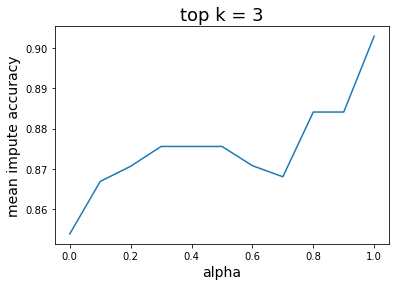

In [56]:
plt.plot(np.arange(0, 1.1, 0.1), y2)
plt.xlabel('alpha', fontsize=14)
plt.ylabel('mean impute accuracy', fontsize=14)
plt.title(f'top k = {top_k}', fontsize=18)
plt.show()

In [67]:
top_k = 2
y2 = []
for alpha in np.arange(0, 1.1, 0.1):
    # normalize model accuracy and impute accuracy
    model_acc = [i['model_accuracy'] for i in outs]
    impute_acc = [i['impute_accuracy'] for i in outs]
    x = [alpha * i['gpt'] + (1-alpha) * ((i['impute_accuracy']-min(impute_acc))/(max(impute_acc) - min(impute_acc))) for i in outs]
    #y = [(i['impute_accuracy']-min(impute_acc))/(max(impute_acc) - min(impute_acc)) for i in outs]
    y = [i['model_accuracy'] for i in outs]
    z = []
    for i in range(len(outs)):
        #plt.text(x[i], y[i], str(outs[i]['bins']))
        z.append((outs[i]['bins'], x[i], y[i]))
        #print(outs[i]['bins'], x[i], y[i])
    sorted(z, key=lambda x: x[1], reverse=True)
    # get mean y[i] for top k
    mean_y = np.mean([i[2] for i in sorted(z, key=lambda x: x[1], reverse=True)[:top_k]])
    y2.append(mean_y)
    print("alpha:", alpha, "mean_y:", mean_y)

alpha: 0.0 mean_y: 0.7203947368421053
alpha: 0.1 mean_y: 0.7203947368421053
alpha: 0.2 mean_y: 0.7203947368421053
alpha: 0.30000000000000004 mean_y: 0.7203947368421053
alpha: 0.4 mean_y: 0.7203947368421053
alpha: 0.5 mean_y: 0.7105263157894737
alpha: 0.6000000000000001 mean_y: 0.7105263157894737
alpha: 0.7000000000000001 mean_y: 0.7105263157894737
alpha: 0.8 mean_y: 0.7105263157894737
alpha: 0.9 mean_y: 0.7105263157894737
alpha: 1.0 mean_y: 0.700657894736842


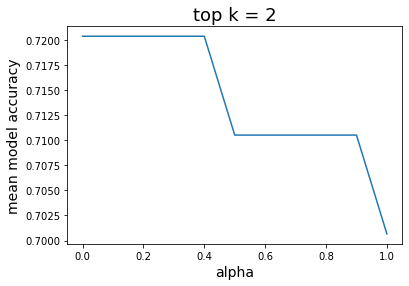

In [68]:
plt.plot(np.arange(0, 1.1, 0.1), y2)
plt.xlabel('alpha', fontsize=14)
plt.ylabel('mean model accuracy', fontsize=14)
plt.title(f'top k = {top_k}', fontsize=18)
plt.show()

### pareto curve

In [110]:
datapoints=np.random.rand(2, 50)
datapoints

array([[0.71691644, 0.59124215, 0.42349582, 0.5939245 , 0.46487134,
        0.62940706, 0.97822296, 0.25388094, 0.15099489, 0.25696939,
        0.62759761, 0.95835526, 0.87314923, 0.48423491, 0.74931096,
        0.54714618, 0.49264806, 0.15866351, 0.74022519, 0.11562332,
        0.37357008, 0.09661767, 0.87647029, 0.28011315, 0.86945105,
        0.04253538, 0.32107033, 0.77506231, 0.11534431, 0.80461076,
        0.86028884, 0.43529135, 0.07122995, 0.57248749, 0.72864558,
        0.24989706, 0.09370352, 0.93149974, 0.66215723, 0.4870712 ,
        0.16350835, 0.54363033, 0.21574577, 0.04054469, 0.5443845 ,
        0.90745565, 0.90212045, 0.21386356, 0.84574628, 0.31890832],
       [0.15699532, 0.99267228, 0.95677354, 0.36654559, 0.03476378,
        0.62153622, 0.80306497, 0.48474144, 0.94582107, 0.12161229,
        0.95510631, 0.71502654, 0.49514553, 0.98142254, 0.24356971,
        0.1677284 , 0.63067456, 0.62808609, 0.59862001, 0.47396508,
        0.07476063, 0.7345975 , 0.19084403, 0.0

In [30]:
datapoints0 = [x['gpt'] for x in outs]
datapoints1 = [x['model_accuracy'] for x in outs]
datapoints2 = [x['impute_accuracy'] for x in outs]
datapoints = np.array([datapoints0[0:], datapoints1[0:]])
datapoints

array([[1.        , 0.66666667, 0.93333333, ..., 0.26666667, 0.26666667,
        0.33333333],
       [0.7012987 , 0.74675325, 0.73376623, ..., 0.70779221, 0.69480519,
        0.70779221]])

In [31]:
pareto=oapackage.ParetoDoubleLong()

for ii in range(0, datapoints.shape[1]):
    w=oapackage.doubleVector( (datapoints[0,ii], datapoints[1,ii]))
    pareto.addvalue(w, ii)

pareto.show(verbose=1)

Pareto: 6 optimal values, 9 objects


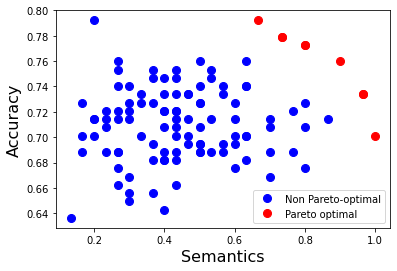

In [32]:
lst=pareto.allindices() # the indices of the Pareto optimal designs

optimal_datapoints=datapoints[:,lst]
# random sample data point index
idx = np.random.choice(range(datapoints.shape[1]), 100)

h=plt.plot(datapoints[0,idx], datapoints[1,idx], '.b', markersize=16, label='Non Pareto-optimal')
hp=plt.plot(optimal_datapoints[0,:], optimal_datapoints[1,:], '.r', markersize=16, label='Pareto optimal')
plt.xlabel('Semantics', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
#plt.xticks([])
#plt.yticks([])
_=plt.legend(loc=0, numpoints=1)

In [33]:
# dictionary to dataframe
df_out = pd.DataFrame(outs)
# label the Pareto optimal points in the dataframe as 1; otherwise 0
df_out['pareto'] = 0
df_out.loc[lst, 'pareto'] = 1
# dataframe to json file
df_out.to_json(os.path.join(ppath, 'scratch', 'glu_bmi_age.pareto.20240725.json'), orient='records')

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=2)
keys = ['Glucose.partitioned', 'BMI.partitioned', 'Age.partitioned']
X = np.array([np.array(i).flatten() for i in df_out[keys].values.tolist()])
X = np.vstack(X)

In [37]:
X.shape

(21952, 2304)

In [38]:
processed = pca.fit_transform(X)

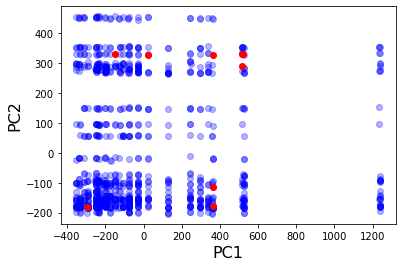

In [56]:
pcadf = pd.DataFrame( data = processed, columns = ['PC1', 'PC2'])
pcadf['pareto'] = df_out['pareto']
# get the index of Pareto optimal points
lst = list(df_out[df_out['pareto']==1].index)
# random sample data point index
#idx = np.random.choice(range(datapoints.shape[1]), 100)
idx = list(df_out[df_out['pareto']==0].index)
idx = np.random.choice(range(len(idx)), 1000)
#pcadf = pcadf.iloc[lst]
# plot the PCA, with Pareto optimal points in red
plt.scatter(pcadf.iloc[idx]['PC1'], pcadf.iloc[idx]['PC2'], c='blue', cmap='coolwarm', alpha=0.3)
plt.scatter(pcadf.iloc[lst]['PC1'], pcadf.iloc[lst]['PC2'], c='r', cmap='coolwarm')
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.show()

In [57]:
import hdbscan

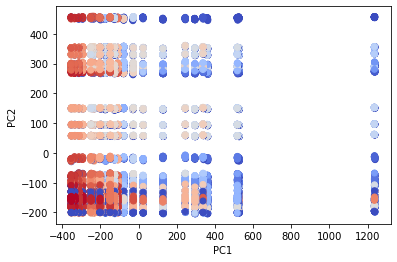

In [81]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
pca = PCA(n_components=20)
processed = pca.fit_transform(X)
hdbscan_clusters = clusterer.fit_predict(processed)
plt.scatter(pcadf['PC1'], pcadf['PC2'], c=hdbscan_clusters, cmap='coolwarm')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [82]:
# number of unique clusters
len(np.unique(hdbscan_clusters))

1216

In [83]:
df_out['cluster'] = hdbscan_clusters
df_out['PC1'] = pcadf['PC1']
df_out['PC2'] = pcadf['PC2']
# for each cluster, get the mean impute accuracy, as a new column 
df_out['cluster_mean'] = df_out.groupby('cluster')['impute_accuracy'].transform('mean')
# for each cluster, compute the confidence interval of the mean impute accuracy
df_out['cluster_std'] = df_out.groupby('cluster')['impute_accuracy'].transform('std')
df_out.sort_values(by='impute_accuracy', ascending=False)

,bins,model_accuracy,Glucose.partitioned,BMI.partitioned,Age.partitioned,gpt,impute_accuracy,pareto,cluster,PC1,PC2,cluster_mean,cluster_std
2464,"[[0.0, 154.0, 199.0], [0.0, 22.367, 44.733, 67...",0.701299,"[154.0, 154.0, 199.0, 154.0, 154.0, 154.0, 154...","[44.733, 44.733, 44.733, 44.733, 44.733, 44.73...","[65.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45....",0.733333,0.947049,0,245,517.373207,330.448732,0.932943,0.008826
896,"[[0.0, 99.5, 199.0], [0.0, 22.367, 44.733, 67....",0.655844,"[99.5, 99.5, 199.0, 199.0, 199.0, 199.0, 99.5,...","[44.733, 44.733, 44.733, 44.733, 44.733, 44.73...","[65.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45....",0.600000,0.938368,0,156,1235.719546,333.000673,0.925492,0.007931
2520,"[[0.0, 154.0, 199.0], [0.0, 26.3, 47.9, 67.1],...",0.759740,"[154.0, 154.0, 199.0, 154.0, 154.0, 154.0, 154...","[47.9, 47.9, 26.3, 47.9, 47.9, 26.3, 47.9, 26....","[65.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45....",0.733333,0.937500,0,245,517.777749,330.815916,0.932943,0.008826
2436,"[[0.0, 154.0, 199.0], [0.0, 26.3, 67.1], [0, 1...",0.766234,"[154.0, 154.0, 199.0, 154.0, 154.0, 154.0, 154...","[67.1, 67.1, 26.3, 67.1, 67.1, 26.3, 67.1, 26....","[65.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45....",0.700000,0.935330,0,-1,519.228514,331.837019,0.838595,0.033852
2471,"[[0.0, 154.0, 199.0], [0.0, 22.367, 44.733, 67...",0.662338,"[154.0, 154.0, 199.0, 154.0, 154.0, 154.0, 154...","[44.733, 44.733, 44.733, 44.733, 44.733, 44.73...","[65.0, 65.0, 65.0, 25.0, 65.0, 65.0, 25.0, 65....",0.633333,0.934896,0,7,516.782317,453.391765,0.894658,0.018435
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16409,"[[0.0, 88.0, 99.0, 107.0, 117.0, 126.375, 140....",0.740260,"[99.0, 88.0, 199.0, 107.0, 140.25, 117.0, 88.0...","[33.7, 33.7, 23.6, 33.7, 67.1, 25.9, 32.0, 23....","[50.0, 32.0, 44.0, 22.0, 34.0, 30.0, 28.0, 30....",0.266667,0.739583,0,905,-311.814656,57.916041,0.748872,0.006811
21113,"[[0.0, 85.0, 95.0, 102.0, 109.0, 117.0, 125.0,...",0.688312,"[102.0, 85.0, 199.0, 109.0, 147.0, 117.0, 85.0...","[33.7, 35.49, 23.6, 33.7, 67.1, 25.9, 32.0, 23...","[50.0, 32.0, 44.0, 22.0, 34.0, 30.0, 28.0, 30....",0.400000,0.739583,0,906,-351.858429,58.538702,0.749096,0.007446
18761,"[[0.0, 87.0, 97.0, 105.0, 112.0, 122.0, 130.0,...",0.727273,"[105.0, 87.0, 199.0, 105.0, 144.0, 122.0, 87.0...","[33.7, 33.7, 23.6, 33.7, 67.1, 25.9, 32.0, 23....","[50.0, 32.0, 46.0, 22.0, 34.0, 30.0, 28.0, 30....",0.400000,0.738715,0,906,-334.065619,58.578005,0.749096,0.007446
21054,"[[0.0, 85.0, 95.0, 102.0, 109.0, 117.0, 125.0,...",0.714286,"[102.0, 85.0, 199.0, 109.0, 147.0, 117.0, 85.0...","[34.733, 37.256, 24.0, 34.733, 67.1, 26.5, 32....","[59.0, 32.0, 46.0, 22.0, 37.0, 32.0, 25.0, 37....",0.400000,0.737847,0,1198,-352.279606,-162.120500,0.750434,0.005916


Text(0, 0.5, 'Number of points')

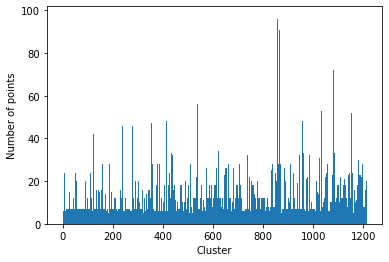

In [84]:
# select clusters not -1
df_no_outliers = df_out[df_out['cluster'] != -1]
# histogram of number of points in each cluster, bin width = 1
plt.hist(df_no_outliers['cluster'], bins=len(np.unique(hdbscan_clusters))-1)
# label the axis
plt.xlabel('Cluster')
plt.ylabel('Number of points')

In [85]:
# biggest cluster
biggest_cluster = df_out['cluster'].value_counts().idxmax()
# number of points in the biggest cluster
df_out['cluster'].value_counts().max()

3614

(array([ 447., 1970., 1945., 3188., 2528., 2384., 1293., 1630.,  757.,
         415.,  110.,  376.,  428.,  210.,  404.,  216.,   12.,    7.,
           6.,   12.]),
 array([0.        , 0.00122849, 0.00245698, 0.00368547, 0.00491397,
        0.00614246, 0.00737095, 0.00859944, 0.00982793, 0.01105642,
        0.01228492, 0.01351341, 0.0147419 , 0.01597039, 0.01719888,
        0.01842737, 0.01965587, 0.02088436, 0.02211285, 0.02334134,
        0.02456983]),
 <BarContainer object of 20 artists>)

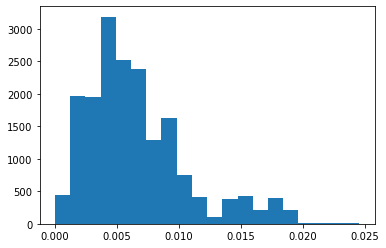

In [86]:
# std distribution
plt.hist(df_no_outliers['cluster_std'], bins=20)

(array([ 15.,  38.,  36., 107., 213., 315., 325., 311., 269., 359., 352.,
        299., 321., 218., 179., 116.,  75.,  47.,  13.,   6.]),
 array([0.75130208, 0.76050347, 0.76970486, 0.77890625, 0.78810764,
        0.79730903, 0.80651042, 0.81571181, 0.82491319, 0.83411458,
        0.84331597, 0.85251736, 0.86171875, 0.87092014, 0.88012153,
        0.88932292, 0.89852431, 0.90772569, 0.91692708, 0.92612847,
        0.93532986]),
 <BarContainer object of 20 artists>)

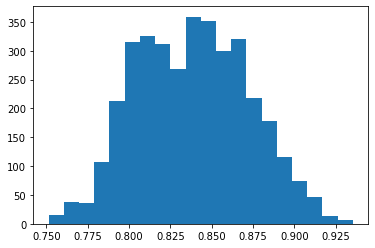

In [87]:
# select clusters -1
df_outliers = df_out[df_out['cluster'] == -1]
# histogram of impure accuracy of outliers
plt.hist(df_outliers['impute_accuracy'], bins=20)

In [104]:
from scipy.spatial import cKDTree
def eval_pareto_points(pareto_points:List, est_pareto_points:List, debug=False) -> float:
    """
    Evaluate the Pareto front using nearest neighbor search.
    Args:
        pareto_points (List): Ground truth Pareto front
        est_pareto_points (List): Estimated Pareto front
    Returns:
        float: Average distance between the estimated and ground truth Pareto fronts
    """
    est_pareto_points = np.array(est_pareto_points)
    pareto_points = np.array(pareto_points)
    # Build KD-tree for fast nearest neighbor search
    tree = cKDTree(est_pareto_points)
    # Find nearest neighbor in estimated curve for each point in ground truth curve
    distances, _ = tree.query(pareto_points)
    # Average distance
    average_distance = np.mean(distances)
    if debug: print(f"Average Distance: {average_distance}")
    return average_distance

def plot_pareto_points(pareto_points:List, est_pareto_points:List):
    """
    Plot the estimated and ground truth Pareto fronts.
    Args:
        pareto_points (List): Ground truth Pareto front
        est_pareto_points (List): Estimated Pareto front
    """
    plt.plot(pareto_points[:, 0], pareto_points[:, 1], 'o-', label='Ground Truth')
    plt.plot(est_pareto_points[:, 0], est_pareto_points[:, 1], 'x-', label='Estimated')
    plt.legend()
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.title('Pareto Curve Comparison')
    plt.show()

def compute_pareto_front(datapoints:List) -> List:
    """
    Compute the Pareto front for a set of data points.
    Args:
        datapoints (List): Data points, 
            where first dimension is semantic similarity and second dimension is utility
    Returns:
        List: Pareto front, a list of indices of the Pareto optimal designs
    """
    datapoints = np.array(datapoints)
    pareto=oapackage.ParetoDoubleLong()
    for ii in range(0, datapoints.shape[1]):
        w=oapackage.doubleVector((datapoints[0,ii], datapoints[1,ii]))
        pareto.addvalue(w, ii)
    lst=pareto.allindices() # the indices of the Pareto optimal designs
    return lst

def get_pareto_points(data, semantic_col:str='gpt', utility_col:str='impute_accuracy') -> List:
    """
    Get the Pareto front from the data.
    Args:
        data (DataFrame): DataFrame containing the data
        semantic_col (str): Column name for semantic similarity
        utility_col (str): Column name for utility
    Returns:
        List: Pareto front
    """
    # Compute Pareto front for the data
    datapoints = [np.array(data[semantic_col]), np.array(data[utility_col])]
    lst = compute_pareto_front(datapoints)
    # label the Pareto optimal points in the dataframe as 1; otherwise 0
    data['pareto'] = 0
    data.loc[lst, 'pareto'] = 1
    # get the Pareto optimal points
    pareto_points = data[data['pareto'] == 1][[semantic_col, utility_col]]
    pareto_points = pareto_points.values.tolist()
    return pareto_points

def cluster_strategies(df_out, semantic_col:str='gpt', utility_col:str='impute_accuracy', debug=False) -> List:
    """
    Cluster the data and estimate the Pareto front.
    Args:
        df_out (DataFrame): DataFrame containing the data
        semantic_col (str): Column name for semantic similarity
        utility_col (str): Column name for utility
    Returns:
        List: Estimated Pareto front
    """
    df = df_out.copy()
    # Cluster the data
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
    pca = PCA(n_components=20)
    #X = list(df['partitioned'].values)
    keys = ['Glucose.partitioned', 'BMI.partitioned', 'Age.partitioned']
    X = np.array([np.array(i).flatten() for i in df_out[keys].values.tolist()])
    X = np.vstack(X)
    processed = pca.fit_transform(X)
    hdbscan_clusters = clusterer.fit_predict(processed)
    # Add the cluster labels to the dataframe
    df['cluster'] = hdbscan_clusters

    # Separate the data into outliers and non-outliers
    df_no_outliers = df[df['cluster'] != -1]
    df_outliers = df[df['cluster'] == -1]

    # For each cluster in the non-outliers, rank the points based on semantic_col
    # and get the top 1 point for each cluster
    top_points = []
    for i in range(df_no_outliers['cluster'].nunique()):
        cluster = df_no_outliers[df_no_outliers['cluster'] == i]
        cluster = cluster.sort_values(by=semantic_col, ascending=False)
        top_points.append(cluster.iloc[0])
    
    # Combine the top points with the outliers, and reset index
    df_top_points = pd.DataFrame(top_points)
    df_combined = pd.concat([df_top_points, df_outliers])
    df_combined = df_combined.reset_index(drop=True)
    print(len(df_combined))

    # Compute pareto front for the combined data
    est_pareto_points = get_pareto_points(df_combined, semantic_col=semantic_col, utility_col=utility_col)

    if debug: print("Estimated Pareto front:", est_pareto_points)
    return est_pareto_points

def sample_strategies(df_out, ratio:float=0.3, semantic_col:str='gpt', utility_col:str='impute_accuracy', debug=False) -> List:
    """
    Sample the data and estimate the Pareto front.
    Args:
        df_out (DataFrame): DataFrame containing the data
        ratio (float): Sampling ratio
        semantic_col (str): Column name for semantic similarity
        utility_col (str): Column name for utility
    Returns:
        List: Estimated Pareto front
    """
    df = df_out.copy()
    # Sample the data
    df_sample = df.sample(frac=ratio, random_state=42)
    # reset index
    df_sample = df_sample.reset_index(drop=True)
    # Compute Pareto front for the sampled data
    est_pareto_points = get_pareto_points(df_sample, semantic_col=semantic_col, utility_col=utility_col)
    
    if debug: print("Estimated Pareto front:", est_pareto_points)
    return est_pareto_points

def rank_strategies(df_out, ratio:float=0.3, semantic_col:str='gpt', utility_col:str='impute_accuracy', debug=False) -> List:
    df = df_out.copy()
    # Rank the data based on semantic_col
    df = df.sort_values(by=semantic_col, ascending=False)
    # Sample the top ratio% of the data
    df_sample = df.head(int(ratio*len(df)))
    # reset index
    df_sample = df_sample.reset_index(drop=True)
    # Compute Pareto front for the sampled data
    est_pareto_points = get_pareto_points(df_sample, semantic_col=semantic_col, utility_col=utility_col)

    if debug: print("Estimated Pareto front:", est_pareto_points)
    return est_pareto_points

In [105]:
print("Number of strategies:", len(outs))
semantic_col = 'gpt'
utility_col = 'impute_accuracy'
# Compute ground truth Pareto front
# dictionary to dataframe
df_out = pd.DataFrame(outs)
datapoints = [np.array(df_out[semantic_col]), np.array(df_out[utility_col])]
lst = compute_pareto_front(datapoints)
# label the Pareto optimal points in the dataframe as 1; otherwise 0
df_out['pareto'] = 0
df_out.loc[lst, 'pareto'] = 1
# get the ground truth Pareto optimal points
pareto_points = df_out[df_out['pareto'] == 1][[semantic_col, utility_col]]
pareto_points = pareto_points.values.tolist()
print("Ground Truth Pareto front:", pareto_points)

# Estimate the Pareto points using clustering
print("====== Clustering strategy ======")
est_pareto_points = cluster_strategies(df_out, semantic_col=semantic_col, utility_col=utility_col, debug=True)
# Average distance
average_distance = eval_pareto_points(pareto_points, est_pareto_points, debug=True)

# Estimate the Pareto front using sampling 
print("====== Sampling strategy ======")
est_pareto_points = sample_strategies(df_out, ratio=0.2, semantic_col=semantic_col, utility_col=utility_col, debug=True)
average_distance = eval_pareto_points(pareto_points, est_pareto_points, debug=True)

# Estimate the Pareto front using semantic similarity ranking
print("====== Semantic similarity ranking strategy ======")
est_pareto_points = rank_strategies(df_out, ratio=0.01, semantic_col=semantic_col, utility_col=utility_col, debug=True)
average_distance = eval_pareto_points(pareto_points, est_pareto_points, debug=True)

Number of strategies: 21952
Ground Truth Pareto front: [[1.0, 0.9088541666666666], [0.7666666666666667, 0.9344618055555557], [0.9666666666666667, 0.9214409722222222], [0.7333333333333334, 0.9470486111111112], [0.8, 0.9279513888888888]]
====== Clustering strategy ======
3443
Estimated Pareto front: [[1.0, 0.9088541666666666], [0.7666666666666667, 0.9253472222222223], [0.9666666666666667, 0.9214409722222222], [0.7333333333333334, 0.9375]]
Average Distance: 0.01041961965793225
====== Sampling strategy ======
Estimated Pareto front: [[0.9333333333333333, 0.8910590277777778], [0.9666666666666667, 0.8815104166666666], [0.8, 0.90234375], [0.8666666666666667, 0.9010416666666666], [0.6666666666666667, 0.9301215277777778], [0.7333333333333334, 0.9270833333333334]]
Average Distance: 0.03255147508921018
====== Semantic similarity ranking strategy ======
Estimated Pareto front: [[1.0, 0.9088541666666666], [0.9666666666666667, 0.9214409722222222], [0.8, 0.9266493055555555]]
Average Distance: 0.02105